In [1]:
%load_ext autotime

In [2]:
import os
from glob import glob
import h5py
import numpy as np
import pandas as pd

from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.offsetbox as offsetbox

from astropy.modeling import models, fitting
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
from astroquery.exoplanet_orbit_database import ExoplanetOrbitDatabase
from astropy.nddata.utils import Cutout2D, PartialOverlapError, NoOverlapError
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c

# Query Exoplanet Orbit Database (exoplanets.org) for planet properties
from astroquery.exoplanet_orbit_database import ExoplanetOrbitDatabase
from astroplan import EclipsingSystem
from astropy.time import Time

import batman

from dateutil.parser import parse as date_parse
from tqdm import tqdm_notebook

from piaa.utils import helpers
from piaa.utils import pipeline


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


ImportError: cannot import name 'db'

time: 2.62 s


#### Observation information

Set up information about the observation sequence. Here we are working with files that have previosly been downloaded.

In [ ]:
base_dir = '/var/panoptes/images/temp/PAN012/20180822T035809/'

In [ ]:
fits_files = sorted(glob(
    os.path.join(base_dir, '2018*.fits')
), )
print("Found {} FITS files".format(len(fits_files)))

In [ ]:
# Get the data and WCS for the first frame
d0 = fits.getdata(fits_files[0])
wcs = WCS(fits_files[0])

In [ ]:
os.environ['PGPASSWORD'] = "pan0pt3&-t3ss"

##### Lookup point sources

By default the first image will be passed to `sextractor` for basic point source detection. This image will then be catalog matched to the TESS (v6) catalog for source identification.

See `pipeline.lookup_point_sources?` for options.

In [7]:
# Lookup the point sources
point_sources = pipeline.lookup_point_sources(
    fits_files, 
    wcs=wcs, 
    force_new=True,
)

print("Found {} sources".format(len(point_sources)))

Found 1141 sources
time: 7.21 s


In [8]:
# Show top entries
point_sources.head()

,x,y,ra,dec,background,flux_auto,flux_max,fluxerr_auto,fwhm,flags,snr,twomass,tmag,vmag,d2d
id,,,,,,,,,,,,,,,
88492408,890.4586,63.7219,304.391749,26.368209,2914.699,33220.620,3642.551,2258.1410,7.23,0,14.711491,20173465+2622131,7.373,7.919,0.002881
88473326,3901.3503,62.9118,304.087702,17.793530,3142.388,11359.230,1872.613,1567.9100,3.45,0,7.244823,20162138+1747370,7.675,8.622,0.001317
304828741,1908.9978,68.0005,304.270718,23.473355,2878.175,7670.520,6100.224,938.3816,0.00,0,8.174201,20170591+2329107,11.479,13.570,0.013440
88393533,1635.5128,66.5553,304.303655,24.252246,3197.187,6494.521,1530.652,1674.7830,0.82,0,3.877828,20171311+2415070,8.768,8.990,0.000910
304608348,2691.8850,70.1567,304.184420,21.240332,3225.460,8699.385,2697.743,1291.8470,2.13,0,6.734068,20164425+2114302,8.348,8.784,0.001371


time: 33.5 ms


In [9]:
# picid = str(point_sources[np.logical_and(
#     point_sources.flags == 0,
#     point_sources.fwhm < 5,
# )].sort_values(['snr', 'fwhm'], ascending=False).index[0])

# picid

time: 1.02 ms


#### Target Information

Lookup information about HD-189733. We use the 2mass ID to query the TESS catalog to get to get the ID, which we refer to as the PANOPTES Input Cataog ID (PICID). _(The PANOPTES catalog is basically the TESS catalog.)_

In [10]:
# HD 189733
picid = str(helpers.get_star_info(twomass_id='20004370+2242391')[0])
picid

'256364928'

time: 335 ms


In [11]:
# Show the sextractor and catalog match info for target
point_sources.loc[int(picid)]

x                        2204.69
y                        1379.59
ra                       300.182
dec                      22.7091
background                3203.3
flux_auto                52207.9
flux_max                 5327.62
fluxerr_auto             1993.78
fwhm                        3.62
flags                          0
snr                      26.1854
twomass         20004370+2242391
tmag                     6.81314
vmag                        7.67
d2d                  0.000871006
Name: 256364928, dtype: object

time: 7.59 ms


#### Create PSC for all sources

Loop through all the detected sources and create a Postage Stamp Cube (PSC) for each source.

These PSC are saved in one HDF5 file named after the observation sequence.

Each PSC is $N \times M$, where $M$ is the squared-size of the side of the postage stamp (i.e. width * height, or a flattened array) and $N$ is the number of frames in the sequence. A stamp will always be square and will have a red pixel in the top-right corner. The stamp size should always be an odd multiple of superpixels (2x2 - RGGB), e.g. 3,5,7 => 3x2=6, 5x2=10, 7x2=14.

> Note: Sources with any `flags` are filtered as well as $vmag < 14$

In [12]:
# Lookup the sequence (for filename)
sequence = fits.getval(fits_files[0], 'SEQID')
sequence

'PAN012_358d0f_20180822T035809'

time: 8.42 ms


In [13]:
# Stamp size should be much larger than source. See above
stamp_size = (14, 14)

time: 2.35 ms


_Note: Process below can be long-running the first time. Subsequent runs just return HDF5 file (unless `force__new=True`)._

In [14]:
# Create stamps
stamps_fn = pipeline.create_stamp_slices(
    sequence,
    fits_files,
    point_sources,
    stamp_size=stamp_size,
#     force_new=True
)
stamps_fn

'/var/panoptes/psc/PAN012_358d0f_20180822T035809.hdf5'

time: 5.75 ms


In [15]:
# Get all the PSC for the observation sequence.
stamps = h5py.File(stamps_fn)
stamps

<HDF5 file "PAN012_358d0f_20180822T035809.hdf5" (mode r+)>

time: 6.56 ms


#### Info about Observation

Get the image times and airmass information. There is currently a [bug](https://github.com/panoptes/POCS/issues/503) with the `DATE-OBS` keyword so we use the filename of the image to generate the timestamps. Otherwise the times would be stored in the `image_times` attribute of the stamps file.

The `airmass` also comes from an attribute.

In [16]:
# Get image times from filename
image_times = [Time(
    date_parse(os.path.splitext(fn.split('/')[-1])[0])
).datetime
for fn in fits_files if 'pointing' not in fn]

time: 62.3 ms


In [17]:
# image_times_mjd = stamps.attrs['image_times'] # MJD
# image_times = [Time(t0, format='mjd').datetime for t0 in image_times_mjd]

airmass = stamps.attrs['airmass'][:-1]

time: 3.35 ms


#### Target PSC

Lookup the target coordinates and check target drift over the course of the observation.

In [18]:
# Lookup target information - HD 189733
# target_coords = SkyCoord('20h00m43.713s +22d42m39.07s')

target_coords = SkyCoord(point_sources.loc[int(picid)].ra * u.deg, point_sources.loc[int(picid)].dec * u.deg)

time: 6.03 ms


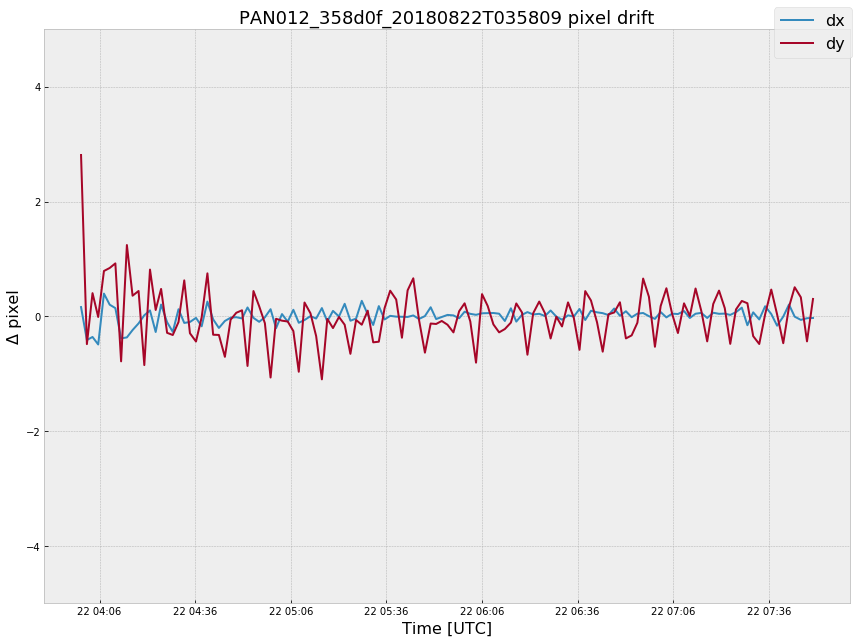

time: 3.72 s


In [19]:
x_pos, y_pos = helpers.get_pixel_drift(target_coords, fits_files)

out_fn = '/var/panoptes/images/temp/PAN012/target_movement.png'

drift_pic = helpers.plot_pixel_drift(
    x_pos, 
    y_pos, 
    index=image_times, 
    out_fn=out_fn,
    title='{} pixel drift'.format(sequence)
)
display(drift_pic)

##### Get target data

We lookup the target PSC from our stamps file, doing a simple bias subtraction directly on the data. This should later be refined with a bias map.

In [20]:
# Simple camera bias
camera_bias = 2048 

time: 854 µs


In [21]:
# Get target PSC and subtract the bias
target_psc = pipeline.get_psc(str(picid), stamps) - camera_bias

time: 3.17 ms


In [22]:
num_frames = target_psc.shape[0]
stamp_side = int(np.sqrt(target_psc.shape[1]))

print("{0} frames of {1}x{1} stamps".format(num_frames, stamp_side))

129 frames of 14x14 stamps
time: 2.25 ms


In [23]:
# Show attributes stored with stamps file
for attr, val in stamps[picid].attrs.items():
    print(attr, val)

ra 300.1815477
dec 22.7091198
twomass 20004370+2242391
vmag 7.670000076293945
tmag 6.813139915466309
flags 0
snr 26.185379623318333
time: 4.25 ms


Here $N = 129$ frames and $M = 196$ for the squared size of the stamp. We roll that back into a regular size (14x14) and animate it:

In [24]:
target_animation = helpers.animate_stamp(
    target_psc.reshape(num_frames, stamp_side, stamp_side)
)

target_animation.save('/var/panoptes/images/temp/PAN012/hd189733.mp4', dpi=150)

time: 14.8 s


In [25]:
display(target_animation)

time: 10.1 s


#### Find similar stars

The target PSC and all source PSC are normalized on a frame-by-frame basis in order to determine the morphology of the source on an invidiual frames. The target PSC is then compared frame by frame for the entire observation sequence, returning the sum of summed squared difference of each target and source frame.

In [26]:
# Removing the last five frames for clouds
frame_slice = slice(0, -12)

time: 1.01 ms


In [27]:
vary_series = pipeline.find_similar_stars(picid, stamps, frame_slice=frame_slice)

time: 1.23 s


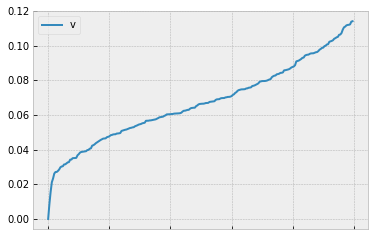

time: 239 ms


In [28]:
# Show the first 250 entries
vary_series[0:250].plot()

#### Build stamp collection

We build a stamp collection of PSCs consisting of the target PSC and its `num_ref` best matches. We again take off a simple bias for each PSC as we go.

We also build a normalized version of the stamp collection.

In [29]:
num_refs = 101  # target + 100

time: 1.17 ms


In [30]:
# Get the target and the top-matching references
stamp_collection = np.array([
    pipeline.get_psc(str(idx), stamps, frame_slice=frame_slice) - camera_bias 
    for idx in vary_series.index[:num_refs]])

time: 65.3 ms


In [31]:
# Get target PSC (may have changed with frame_slice)
target_psc = stamp_collection[0]

num_frames = stamp_collection.shape[1]

time: 1.78 ms


In [32]:
# Get a normalized version of the entire stamp collection
normalized_collection = np.array([pipeline.normalize(s) for s in stamp_collection])

time: 30.2 ms


#### Build reference coeffecients

In [33]:
# Get the coefficients the most optimally combine the normalized referenes into 
# one single master reference.
coeffs = pipeline.get_ideal_full_coeffs(normalized_collection)

time: 102 ms


#### Build reference PSC

In [34]:
# Use the coeffecients generated from the normalized references and
# apply them to the non-normalized (i.e. flux) stamps
ideal_psc = pipeline.get_ideal_full_psc(
    stamp_collection, 
    coeffs[0]
).reshape(num_frames, -1)

time: 10.7 ms


Animate the reference stamp similar to the target stamp

In [35]:
# Animate the ideal reference
ref_animation = helpers.animate_stamp(
    ideal_psc.reshape(num_frames, stamp_side, stamp_side)
)

ref_animation.save('/var/panoptes/images/temp/PAN012/hd189733_ref.mp4', dpi=150)

display(ref_animation)

time: 22.4 s


#### Show Target and reference comparison

We look at a single frame on both the target and the reference as well as the residual.

In [36]:
frame_idx = 3

time: 1.06 ms


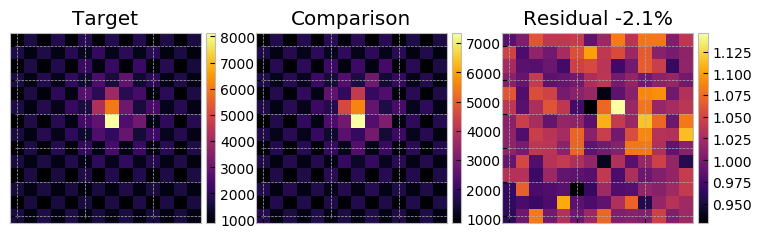

time: 896 ms


In [37]:
# Reshape into square stamps and plot the requested frame
stamp_fig = plot.show_stamps([
    target_psc.reshape(num_frames, stamp_side, stamp_side), 
    ideal_psc.reshape(num_frames, stamp_side, stamp_side)
], frame_idx=frame_idx, show_residual=True)

stamp_fig.savefig('/var/panoptes/images/temp/PAN012/target_comparison.png', dpi=150)

display(stamp_fig)

#### Differential Aperture photometry

Split into color channels and put an aperture around the source for both target and reference. Currently centroided by brightest pixel - needs improvement. Collect target and reference counts.

Default aperture size is 4 pixels but this should also be adaptive in some sense.

In [38]:
lc0 = pipeline.differential_photometry(target_psc, ideal_psc, image_times, aperture_size=5)

time: 299 ms


In [62]:
# Save the lightcurve dataframe to a csv file

# NOTE: We do this before normalizing
csv_file = '/var/panoptes/images/temp/PAN012/{}_{}_lc.csv'.format(
    sequence.replace('/', '_'), 
    picid
)

lc0.to_csv(csv_file)

time: 7.54 ms


In [198]:
exp_time = fits.getval(fits_files[0], 'exptime')
exp_time

34.9

time: 7.78 ms


In [242]:
# We are using all color channels combined for now
lc1 = lc0.groupby('obstime').sum()

# Redo the relative flux with new sums
lc1['rel_flux'] = (lc1.target / lc1.reference)

lc1['target_mag'] = get_imag(lc1.target, t=exp_time)
lc1['reference_mag'] = get_imag(lc1.reference, t=exp_time)

pre_ingress_flux = lc1.loc[lc1.index < ingress].rel_flux
post_egress_flux = lc1.loc[lc1.index > egress].rel_flux

# Normalize the entire observation relative flux by the pre-ingress mean
lc1['rel_flux'] = sigma_clip(lc1.rel_flux / pre_ingress_flux.mean()).filled(1)

# Normalize by the mean
# lc1['rel_flux'] = sigma_clip(lc1.rel_flux / lc1.rel_flux.mean()).filled(1)

time: 21.8 ms


In [243]:
# Show top entries
lc1.head()

,reference,rel_flux,target,target_mag,reference_mag
obstime,,,,,
2018-08-22 04:00:12,65372,1.007881,67795,-8.220931,-8.181416
2018-08-22 04:02:02,66791,0.999840,68714,-8.235550,-8.204731
2018-08-22 04:03:48,65738,1.000865,67700,-8.219408,-8.187478
2018-08-22 04:05:35,66441,0.997720,68209,-8.227541,-8.199027
2018-08-22 04:07:23,66282,1.007533,68715,-8.235565,-8.196425


time: 10.4 ms


#### Exoplanet properties

See https://astroplan.readthedocs.io/en/latest/tutorials/periodic.html

In [244]:
planet_properties = ExoplanetOrbitDatabase.query_planet('HD 189733 b')

# get relevant planet properties
epoch = Time(planet_properties['TT'], format='jd')
period = planet_properties['PER']
transit_duration = planet_properties['T14']

print('Mid-transit time reference: {0}; period reference: {1}'
      .format(planet_properties['TTREF'], planet_properties['PERREF']))

Mid-transit time reference: Agol 2010; period reference: Agol 2010
time: 5.75 ms


In [245]:
# Create an EclipsingSystem object for HD 189733
hd189733 = EclipsingSystem(primary_eclipse_time=epoch, 
                           orbital_period=period,
                           duration=transit_duration
                          )

time: 1.98 ms


In [246]:
# Calculate next transit times which occur after first image
obs_time = Time(image_times[0])

next_transit = hd189733.next_primary_eclipse_time(obs_time)

time: 3.69 ms


In [247]:
# Get the ingress and egress times for the transit
ing_egr = hd189733.next_primary_ingress_egress_time(obs_time)

time: 4.4 ms


In [248]:
# Get transit properties
midpoint = next_transit[0].datetime
ingress = ing_egr.datetime[0][0]
egress = ing_egr.datetime[0][1]

time: 2.32 ms


#### Show observation and transit info

Plot the airmass of each observation along with the transit overlap.

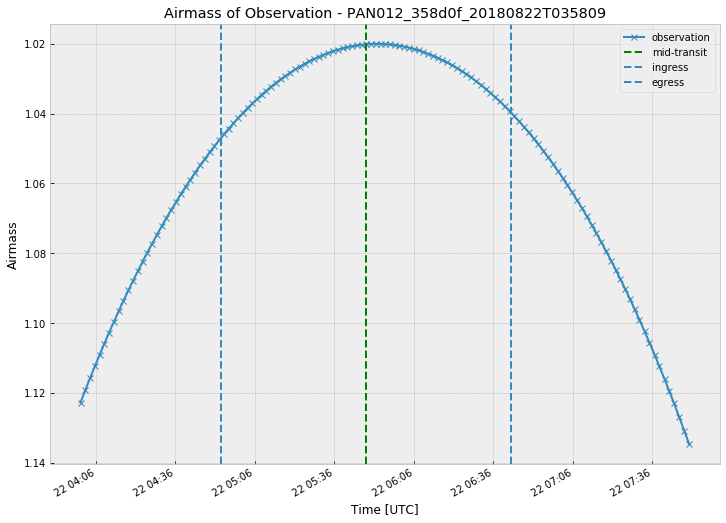

time: 625 ms


In [249]:
pd.Series(airmass, index=image_times).plot(figsize=(12, 9), marker='x', label='observation')

plt.gca().invert_yaxis()
plt.ylabel('Airmass')
plt.xlabel('Time [UTC]')

plt.title('Airmass of Observation - {}'.format(sequence))

plt.axvline(midpoint, label='mid-transit', ls='--', c='g')
plt.axvline(ingress, label='ingress', ls='--')
plt.axvline(egress, label='egress', ls='--')

plt.legend()
plt.savefig('/var/panoptes/images/temp/PAN012/airmass_with_transit.png')

Get both the time delta (in days) as well as the orbital phase of the exoplanet.

In [250]:
# Get the time offsets as the delta (in days) from the midpoint
delta_days_before = [
    -1 * ((midpoint - t0).seconds * u.second).to(u.day).value 
    for t0 in lc1.index if t0 < midpoint
]

delta_days_after = [
    ((t0 - midpoint).seconds * u.second).to(u.day).value 
    for t0 in lc1.index if t0 >= midpoint
]

delta_days = np.array(delta_days_before + delta_days_after)

# Get the orbital phase of the exoplanet
orbital_phase = np.array([helpers.get_planet_phase(period.value, midpoint, t0) for t0 in lc1.index])

time: 66.8 ms


##### Transit Model

We use the [`batman`](https://www.cfa.harvard.edu/~lkreidberg/batman/index.html) package to generate a model of the transit for HD189733. Here we set up the parameters but wait to build the model below when we have the final light-curve info.

In [251]:
# http://exoplanet.eu/catalog/hd_189733_b/
stellar_radius = (0.805 * u.R_sun)
semimajor_axis = (0.0312 * u.au).to(u.R_sun)
sm_axis = semimajor_axis / stellar_radius
eccentricity = 0.0041
planet_radius = 0.116 # Stassun et al. 2017

transit_params = batman.TransitParams() #object to store transit parameters
transit_params.t0 = 0.                  #time of inferior conjunction
# transit_params.per = 1.                 #orbital period
transit_params.per = period.value

transit_params.rp = planet_radius               #planet radius (stellar radii)
transit_params.inc = 85.7               #orbital inclination (degrees) - Stassun et al. 2017

# transit_params.a = semimajor_axis              #semi-major axis (stellar radii)
transit_params.a = sm_axis
transit_params.ecc = eccentricity

transit_params.w = 90.                  #longitude of periastron (in degrees)

transit_params.limb_dark = "uniform"    #limb darkening model
transit_params.u = []                   #limb darkening coefficients [u1, u2, u3, u4]

time: 3.5 ms


In [252]:
# Build transit model
base_transit_model = batman.TransitModel(transit_params, delta_days)

# Get model flux
base_model_flux = base_transit_model.light_curve(transit_params)

base_model_imag = get_imag(base_model_flux, t=exp_time)

time: 1.84 ms


In [253]:
radius_range = np.linspace(0.11, 0.2, 1000)
sma_range = np.linspace(5, 9, 1000)
period_range = np.linspace(2.0, 2.5, 1000)

time: 2.22 ms


In [254]:
pp = list()

for i in range(len(radius_range)):
    r0 = radius_range[i]
    a0 = sma_range[i]
    p0 = period_range[i]
    
    transit_params.rp = r0
    transit_params.a = a0
    transit_params.per = p0
    
    # Build transit model
    transit_model = batman.TransitModel(transit_params, delta_days)

    # Get model flux
    model_flux = transit_model.light_curve(transit_params)
    
    std0 = (lc1.rel_flux - model_flux).std()
    
    pp.append([r0,a0,p0,std0])

time: 431 ms


In [255]:
pp0 = pd.DataFrame(pp, columns=['radius', 'a', 'period', 'std0']).sort_values(['std0'])

time: 4.52 ms


In [256]:
lowest_index = pp0.index[0]

time: 1.08 ms


In [257]:
transit_params.rp = pp0.loc[lowest_index].radius
transit_params.a = pp0.loc[lowest_index].a
transit_params.per = pp0.loc[lowest_index].period

model_transit_depth = (planet_radius / stellar_radius.value)**2
fit_transit_depth = (transit_params.rp / stellar_radius.value)**2

props = """Transit model:
Radius:    {:.05}
Semi-Axis: {:.05}
Period:    {:.05}
Depth:     {:.02}


Transit fit:
Radius:    {:.05}
Semi-Axis: {:.05}
Period:    {:.05}
Depth:     {:.02}""".format(
    planet_radius, semimajor_axis.value, period.value, model_transit_depth,
    transit_params.rp, transit_params.a, transit_params.per, fit_transit_depth
)


print(props)

# Build transit model
transit_model = batman.TransitModel(transit_params, delta_days)

# Get model flux
model_flux = transit_model.light_curve(transit_params)

Transit model:
Radius:    0.116
Semi-Axis: 6.709
Period:    2.2186
Depth:     0.021


Transit fit:
Radius:    0.11766
Semi-Axis: 5.3403
Period:    2.0425
Depth:     0.021
time: 5.24 ms


#### Plot lightcurve

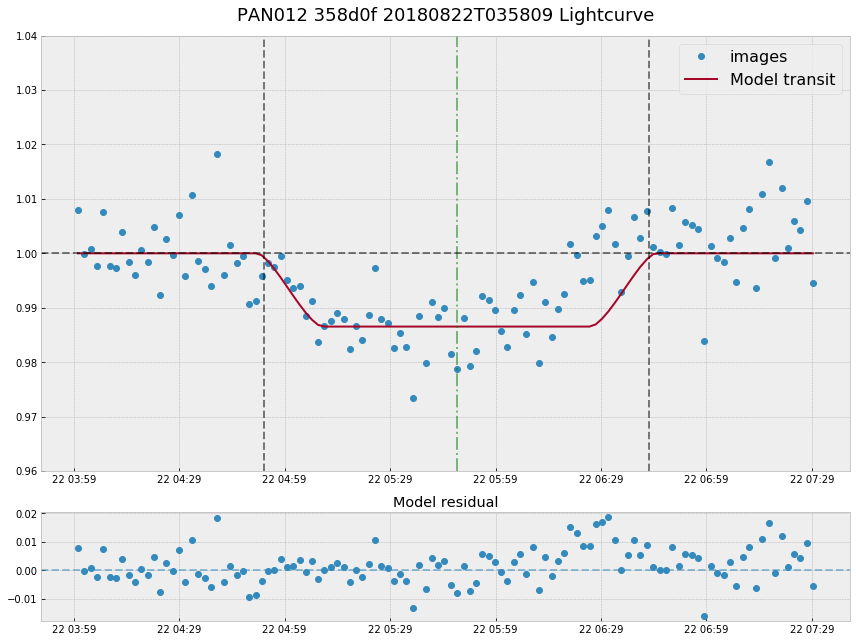

time: 1.17 s


In [258]:
# Plot the lightcurve
lc_fig = pipeline.plot_lightcurve(lc1, base_model_flux, [midpoint, ingress, egress],
    title="{} Lightcurve".format(sequence.replace('_', ' ')),
    ylim=[.96, 1.04]
)

# lc_fig = pipeline.plot_lightcurve(
#     lc1, 
#     np.ones_like(lc1.rel_flux.values),
#     title="{} Lightcurve".format(sequence.replace('_', ' ')),
#     ylim=[.96,1.04]
# )

# tmid = stamps[picid].attrs['twomass']
# lc_fig.suptitle('2MASS J{}'.format(tmid), y=0.95, fontsize=16)

# box_text = 'σ = {:.05}'.format(lc1.rel_flux.std())
# ob = offsetbox.AnchoredText(box_text, loc=1, prop=dict(size=12, family="monospace"))
# ob.patch.set(boxstyle='square,pad=0.2', alpha=0.85)
# lc_fig.axes[1].add_artist(ob)

# Add some properties
# ob = offsetbox.AnchoredText(props, loc=2, prop=dict(size=12, family="monospace"))
# ob.patch.set(boxstyle='square,pad=0.2', alpha=0.85)
# lc_fig.axes[0].add_artist(ob)

# lc_fig.axes[0].plot(lc1.index, model_flux, c='r', ls='--', label='Transit fit')
# lc_fig.axes[0].legend()

# residual = lc1.rel_flux - model_flux
# lc_fig.axes[1].plot(lc1.index, residual, c='r', ls='', marker='x', label='Fit {:.04f}'.format(residual.std()))
# lc_fig.axes[1].legend(loc=1, fontsize=14)

lc_fig.savefig('/var/panoptes/images/temp/PAN012/final_lc_fit_{}.png'.format(picid), 
               dpi=150, transparent=False)

display(lc_fig)

In [115]:
lcax = lc_fig.axes[0]

time: 960 µs


In [116]:
l = lcax.get_lines()[1]

time: 1.03 ms


In [117]:
l.set_linewidth(12)

time: 1.08 ms


In [119]:
lc_fig.savefig('/var/panoptes/images/temp/PAN012/final_lc_fit_{}.png'.format(picid), 
               dpi=150, transparent=False)

time: 596 ms


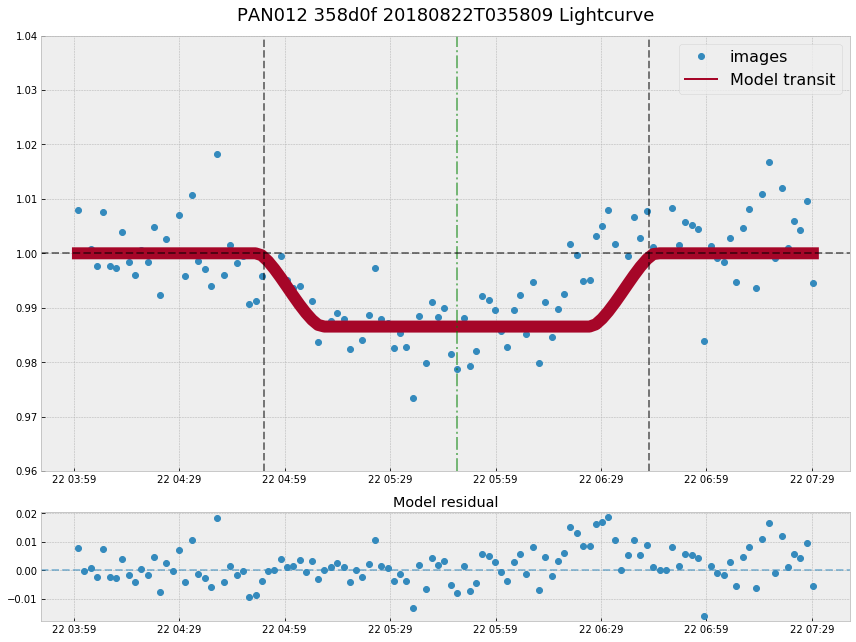

time: 469 ms


In [118]:
display(lc_fig)

Make a mini lightcurve

In [146]:
d0 = target_psc[5].reshape(14, 14)

pix_idx = np.argwhere(d0 == d0.max())[0]

time: 1.41 ms


In [160]:
pix_idx + (2, 3)

array([ 8, 11])

time: 3.73 ms


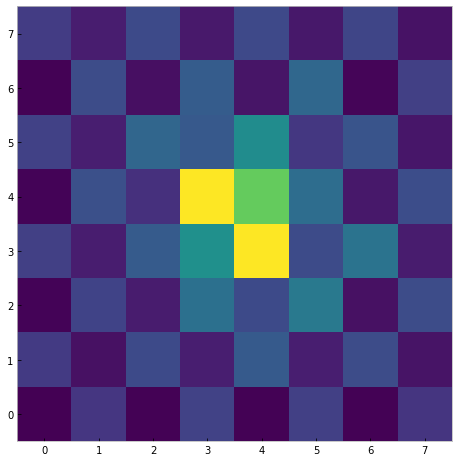

time: 273 ms


In [184]:
plt.figure(figsize=(8, 8))
plt.imshow(Cutout2D(d0, pix_idx + (2, -1), 8).data, cmap='viridis')
plt.grid(False)

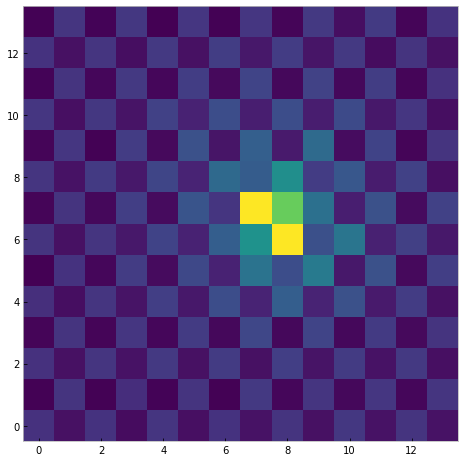

time: 297 ms


In [132]:
plt.figure(figsize=(8,8))
plt.imshow(target_psc[5].reshape(14, 14))
plt.grid(False)

In [133]:
from astropy.nddata import Cutout2D

time: 933 µs


In [194]:
fits.getval(fits_files[0], 'EXPTIME')

34.9

time: 8.4 ms


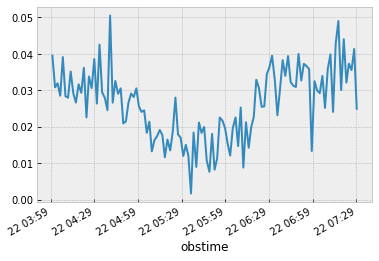

time: 228 ms


In [195]:
(get_imag(lc1.reference, t=35) - get_imag(lc1.target, t=35)).plot()

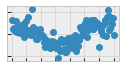

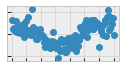

time: 286 ms


In [58]:
fig, ax = plt.subplots(1)

fig.set_size_inches([2, 1])

ax.plot(lc1.index, lc1.rel_flux.values, marker='o', ls='')
ax.set_xticklabels([])
ax.set_yticklabels([])

display(fig)